Implementation of the Cyclical Learning Rate and its 1-Cycle Policy as a Keras's callback.

**Me**: https://github.com/tisu19021997

**Original papers**:

*   Leslie N.Smith, "*Cyclical Learning Rates for Training Neural Networks*" (2015)
*   Leslie N.Smith, "*A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay*" (2018)
* Frank Hutter et al., "*SGDR: Stochastic Gradient Descent with warm restarts*" (2017) 

**Other preferences**:
* https://github.com/bckenstler/CLR
* https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR


**TODO**:
  - [x] Cyclical Momentum
  - [ ] Learning Rate finder (similar to the one that [fastai][fastai_lr_finder] implemented)
  - [x] ~~Consine Annealing (like [PyTorch's][PyTorch])~~

[fastai_lr_finder]: https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
[PyTorch]: https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#CosineAnnealingWarmRestarts

# Prepare the data

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.3.0


In [ ]:
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)

X_train_scaled = (X_train - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

# Implement Cyclical LR as a Keras's callback

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import Callback
from keras import backend as K

class _CyclicalScheduler(Callback):
  def __init__(self, 
               max_lr,
               base_lr=None,
               div_factor=20,
               cyclical_momentum=True,
               base_momentum=0.85,
               max_momentum=0.95):
    
    """Base class for cyclical learning rate scheduler.

    Args:
      max_lr (float): The upper learning rate bound in the cycle.
      base_lr (float): The lower learning rate bound or the initial learning rate in the cycle. 
        If not provided, it is determined as max_lr/div_factor.
        Default: None
      div_factor (float or int): Determines the lower learning rate bound as max_lr/div_factor.
        Default: 20
      cyclical_momentum (bool): If ``True``, cyclical momentum will be used.
        Default: True
      base_momentum (float): The lower momentum bound or the initial momentum in the cycle.
        Default: 0.85
      max_momentum (float): The upper momentum bound in the cycle.
        Default: 0.95
    """
    super().__init__()

    if not max_lr and not base_lr:
      raise ValueError('Either max_lr or base_lr must be defined.')
    elif max_lr and base_lr:
      self.max_lr = max_lr
      self.base_lr = base_lr
    elif max_lr:
      self.max_lr = max_lr
      self.base_lr = max_lr / div_factor
    else:
      self.max_lr = base_lr * div_factor
      self.base_lr = base_lr

    # It is called "epochCounter" in the original papper. However,
    # it increases after each batch ends, therefore, I call it batch_counter.
    self.batch_counter = 0
    self.train_iterations = 0
    self.cyclical_momentum = cyclical_momentum
    self.base_momentum = base_momentum
    self.max_momentum = max_momentum
    self.history = {}

    self._reset()

  def _reset(self):
    # Reset the batch counter. 
    self.batch_counter = 0

  def get_momentum(self):
    raise NotImplementedError

  def get_lr(self):
    raise NotImplementedError

  def plot_lr(self, figsize=(10, 3)):
    if not self.train_iterations or not self.history:
      raise ValueError('Nothing to plot. Train the model first.')
    
    totals = 1
    cols = 1
    y = [self.history['lrs']]
    x = self.history['iterations']
    ylabels = ['Learning Rate']
    
    if self.cyclical_momentum:
      totals += 1
      cols += 1
      y.append(self.history['moms'])
      ylabels.append('Momentum')

    position = range(1, totals + 1)
    fig = plt.figure(figsize=figsize)

    for i in range(totals):
      ax = fig.add_subplot(1, cols, position[i])
      ax.plot(x, y[i])
      ax.set_xlabel('Iteration')
      ax.set_ylabel(ylabels[i])

    fig.tight_layout(pad=3.0)
    plt.show()

  def plot_train_accr_lr(self):
    if not self.batch_counter or not self.history:
      raise ValueError('Nothing to plot. Train the model first.')
    
    accs = self.history['accuracy']
    lrs = self.history['lrs']

    # max_y = np.max(accs)
    # max_x = np.max(lrs)
    # min_x = np.min(lrs)

    plt.title('Train Accuracy vs Learning Rate')
    plt.plot(lrs, accs)
    # plt.plot([min_x, max_x], [max_y, max_y], 'r--')
    plt.xlabel('Learning Rate')
    plt.ylabel('Train Accuracy')

  def _check_support(self):
    if not hasattr(self.model.optimizer, 'lr'):
      raise ValueError('Optimizer must have a "lr" attribute to use cyclical learning rate.')

    if self.cyclical_momentum and not hasattr(self.model.optimizer, 'momentum'):
      raise ValueError('Optimizer must have a "momentum" attribute to use cyclical momentum.')

  def on_train_begin(self, logs={}):
    self._check_support()
    logs = logs or {}

    if self.batch_counter == 0:
      K.set_value(self.model.optimizer.lr, self.base_lr)

      if self.cyclical_momentum:
        K.set_value(self.model.optimizer.momentum, self.max_momentum)
    else:
      K.set_value(self.model.optimizer.lr, self.get_lr())

      if self.cyclical_momentum:
        K.set_value(self.model.optimizer.momentum, self.get_momentum())

  def on_batch_end(self, epoch, logs={}):
    self._check_support()
    logs = logs or {}

    # Increase the epoch counter.
    self.batch_counter += 1
    self.train_iterations += 1

    # Keep track of the learning rates.
    self.history.setdefault('lrs', []).append(K.get_value(self.model.optimizer.lr))
    self.history.setdefault('iterations', []).append(self.train_iterations)
    K.set_value(self.model.optimizer.lr, self.get_lr())

    # Also keep track of accuracy.
    for key, value in logs.items():
      self.history.setdefault(key, []).append(value)

    # self.history.setdefault('accuracy', []).append(logs['accuracy'])

    # Keep track of momentums if supported.
    if self.cyclical_momentum:
      self.history.setdefault('moms', []).append(K.get_value(self.model.optimizer.momentum))
      K.set_value(self.model.optimizer.momentum, self.get_momentum())
      

In [ ]:
import numpy as np

class CyclicalLR(_CyclicalScheduler):
  def __init__(self,
               max_lr,
               base_lr=None,
               div_factor=20,
               cyclical_momentum=True,
               base_momentum=0.85,
               max_momentum=0.95,
               step_size=2000.0,
               policy='triangular',
               gamma=1.0,
               scale_mode='cycle',
               scaler=None):
    """Sets the learning rate according to the cyclical learning rate policy (CLR)
    mentioned in `Cyclical Learning Rates for Training Neural Networks`_. The policy varies 
    the learning rate (in some cases, and the momentum) between the upper bound and
    the lower bound. Note that the policy updates the learning rate after very batch.

    There are 3 CLR policies implemented in this class:
      1. "triangular": A triangular cycle without amplitude scaling.
      2. "triangular2": The same as the "triangular" except the learning rate difference
      is cut in half at the end of each cycle.
      3. "exp_range": The boundaries are declined by an exponential factor of :math:`\text{gamma}^{\text{cycle iterations}}` 

    Args:
      max_lr (float): The upper learning rate bound in the cycle.
      base_lr (float): The lower learning rate bound or the initial learning rate in the cycle. 
        If not provided, it is determined as max_lr/div_factor.
        Default: None
      div_factor (float or int): Determines the lower learning rate bound as max_lr/div_factor.
        Default: 20
      cyclical_momentum (bool): If ``True``, cyclical momentum will be used.
        Default: True
      base_momentum (float): The lower momentum bound or the initial momentum in the cycle.
        Default: 0.85
      max_momentum (float): The upper momentum bound in the cycle.
        Default: 0.95
      step_size (float): The number of training iterations in half a cycle. Since, cycle=step_size*2
        Default: 2000.0
      policy (string): One of {triangular, triangular2, exp_range}. Each comes with a different scaler.
        If scaler is defined, this argument is ignored.
        Default: 'triangular'
      gamma (float): Constant used in 'exp_range' scaler.
        Default: 1.0
      scale_mode (str): One of {'cycle', 'iterations'}. Scaling mode of the scaler.
        Default: 'cycle'
      scaler (function): Custom scaler. Notice that the result of the scaler should be between 0 and 1.
        Default: None.

      .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    """
    super().__init__(max_lr, base_lr, div_factor, cyclical_momentum, base_momentum, max_momentum)

    if policy not in ['triangular', 'triangular2', 'exp_range']:
      raise ValueError('Supported policies are "triangular", "triangular2", and "exp_range"')
    
    self.step_size = step_size
    self.policy = policy
    self.gamma = gamma
    
    if not scaler:
      if self.policy == 'triangular':
        self.scaler = self._triangular_scaler
        self.scale_mode = 'cycle'
      elif self.policy == 'triangular2':
        self.scaler = self._triangular2_scaler
        self.scale_mode = 'cycle'
      else:
        self.scaler = self._exp_range_scaler
        self.scale_mode = 'iterations'
    else:
      self.scaler = scaler
      self.scale_mode = scale_mode
      
  def _triangular_scaler(self, x):
    return 1

  def _triangular2_scaler(self, x):
    return 1.0 / (2.0 ** (x - 1))

  def _exp_range_scaler(self, x):
    return self.gamma**x

  def get_lr(self):
    # Calculate the current cycle.
    cycle = np.floor(1 + self.batch_counter/(2 * self.step_size))

    # x will be negative so (1-x) will be positive on the first half of a cycle, therefore, the learning rate will go up.
    # On the other hand, it will be positive so (1-x) will be negative on the second half of a cycle, makes the learning rate go down.
    x = np.abs(1 + self.batch_counter/self.step_size - 2 * cycle)

    # Update the learning rate.
    lr = (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))

    if self.scale_mode == 'cycle':
      lr *= self.scaler(cycle)
    else:
      lr *= self.scaler(self.batch_counter)

    return self.base_lr + lr

  def get_momentum(self):
    cycle = np.floor(1 + self.batch_counter/(2 * self.step_size))
    x = np.abs(1 + self.batch_counter/self.step_size - 2 * cycle)
    momentum = (self.max_momentum - self.base_momentum) * max(0, (1 - x))

    if self.scale_mode == 'cycle':
      momentum *= self.scaler(cycle)
    else:
      momentum *= self.scaler(self.batch_counter)

    return self.max_momentum - momentum


# Build a new model using the pretrained VGG16


In [ ]:
from keras.applications.vgg16 import VGG16
from keras import Model

def build_vgg16_model():
  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)
  
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
  # Freeze all layers
  base_model.trainable = False
  
  # Add a model on top of the pretrained VGG16.
  inputs = keras.Input(shape=(32, 32, 3))
  outputs = base_model(inputs, training=False)
  x = keras.layers.Flatten()(outputs)
  x = keras.layers.Dense(512, activation='relu')(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  # x = keras.layers.Dense(4096, activation='elu', kernel_initializer='he_normal')(x)
  # x = keras.layers.Dense(4096, activation='elu', kernel_initializer='he_normal')(x)
  x = keras.layers.Dense(10, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  optimizer = keras.optimizers.Nadam()

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])
  
  return model

def build_momentum_vgg16_model():
  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)
  
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
  # Freeze all layers
  base_model.trainable = False
  
  # Add a model on top of the pretrained VGG16.
  inputs = keras.Input(shape=(32, 32, 3))
  outputs = base_model(inputs, training=False)
  x = keras.layers.Flatten()(outputs)
  x = keras.layers.Dense(512, activation='relu')(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  # x = keras.layers.Dense(4096, activation='elu', kernel_initializer='he_normal')(x)
  # x = keras.layers.Dense(4096, activation='elu', kernel_initializer='he_normal')(x)
  x = keras.layers.Dense(10, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  optimizer = keras.optimizers.SGD(momentum=0.009)

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])
  
  return model

In [ ]:
def build_simple_model():
  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)

  # Simple 3-layer model
  model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=(32, 32, 3)),
      keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
      keras.layers.Dense(10, activation='softmax'),
  ])

  optimizer = keras.optimizers.Nadam(lr=base_lr)

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

# Cyclical LR

In [ ]:
# Define some constants
batch_size = 512
epochs = 5
step_size = 98
base_lr = 0.001
max_lr = 0.006

## Triangular Policy

In [ ]:
model = build_momentum_vgg16_model()

clr = CyclicalLR(max_lr=max_lr, base_lr=base_lr, step_size=step_size)

history = model.fit(X_train_scaled, y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_test_scaled, y_test),
          callbacks=[clr])

Epoch 1/5
98/98 [==============================] - 6s 64ms/step - loss: 1.9526 - accuracy: 0.3310 - val_loss: 1.5425 - val_accuracy: 0.4793
Epoch 2/5
98/98 [==============================] - 6s 61ms/step - loss: 1.4015 - accuracy: 0.5194 - val_loss: 1.3170 - val_accuracy: 0.5391
Epoch 3/5
98/98 [==============================] - 6s 61ms/step - loss: 1.2702 - accuracy: 0.5604 - val_loss: 1.2486 - val_accuracy: 0.5623
Epoch 4/5
98/98 [==============================] - 6s 62ms/step - loss: 1.1967 - accuracy: 0.5864 - val_loss: 1.1853 - val_accuracy: 0.5842
Epoch 5/5
98/98 [==============================] - 6s 63ms/step - loss: 1.1516 - accuracy: 0.6018 - val_loss: 1.1487 - val_accuracy: 0.5984


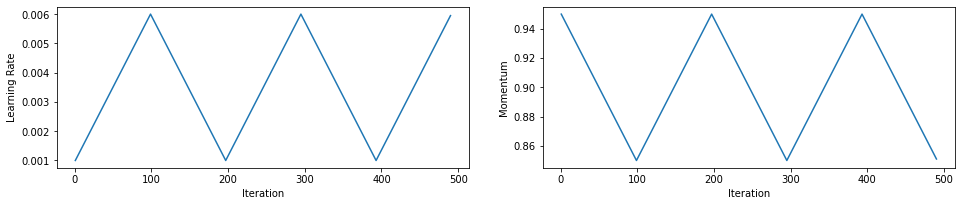

In [ ]:
clr.plot_lr((14, 3.5))

## Triangular2 Policy


In [ ]:
model = build_momentum_vgg16_model()

clr = CyclicalLR(policy='triangular2', max_lr=max_lr, base_lr=base_lr, step_size=step_size, cyclical_momentum=True)

history = model.fit(X_train_scaled, y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_test_scaled, y_test),
          callbacks=[clr])

Epoch 1/5
98/98 [==============================] - 6s 65ms/step - loss: 1.9526 - accuracy: 0.3310 - val_loss: 1.5425 - val_accuracy: 0.4793
Epoch 2/5
98/98 [==============================] - 6s 61ms/step - loss: 1.4015 - accuracy: 0.5194 - val_loss: 1.3170 - val_accuracy: 0.5391
Epoch 3/5
98/98 [==============================] - 6s 61ms/step - loss: 1.2721 - accuracy: 0.5613 - val_loss: 1.2424 - val_accuracy: 0.5660
Epoch 4/5
98/98 [==============================] - 6s 60ms/step - loss: 1.2037 - accuracy: 0.5839 - val_loss: 1.1957 - val_accuracy: 0.5807
Epoch 5/5
98/98 [==============================] - 6s 60ms/step - loss: 1.1624 - accuracy: 0.5988 - val_loss: 1.1617 - val_accuracy: 0.5937


The LR is cut in half for each cycle (equals to 2 steps)

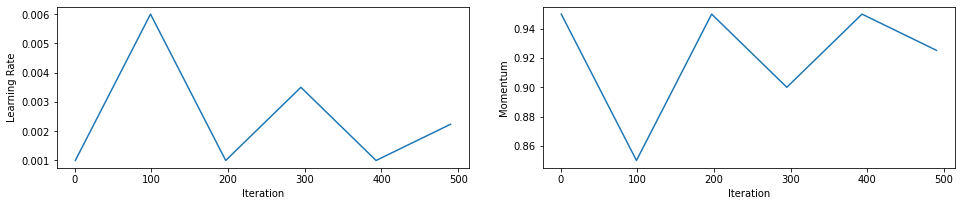

In [ ]:
clr.plot_lr((14,3.5))

## Exponential Range Policy


Epoch 1/5
196/196 [==============================] - 7s 34ms/step - loss: 1.6861 - accuracy: 0.4219 - val_loss: 1.3237 - val_accuracy: 0.5348
Epoch 2/5
196/196 [==============================] - 6s 33ms/step - loss: 1.2454 - accuracy: 0.5690 - val_loss: 1.1970 - val_accuracy: 0.5820
Epoch 3/5
196/196 [==============================] - 6s 32ms/step - loss: 1.1503 - accuracy: 0.5992 - val_loss: 1.1455 - val_accuracy: 0.6018
Epoch 4/5
196/196 [==============================] - 6s 33ms/step - loss: 1.0994 - accuracy: 0.6194 - val_loss: 1.1010 - val_accuracy: 0.6127
Epoch 5/5
196/196 [==============================] - 6s 33ms/step - loss: 1.0679 - accuracy: 0.6317 - val_loss: 1.0801 - val_accuracy: 0.6198


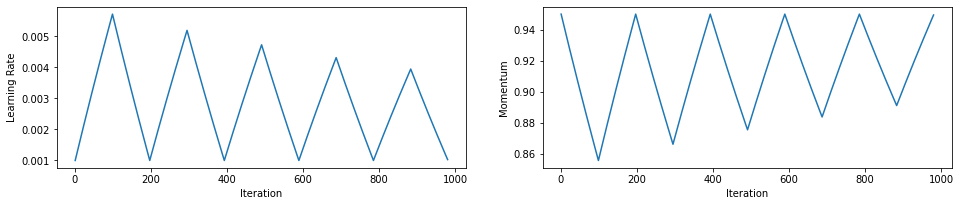

In [ ]:
model = build_momentum_vgg16_model()

clr = CyclicalLR(policy='exp_range', gamma=0.9994, max_lr=max_lr, base_lr=base_lr, step_size=step_size, cyclical_momentum=True)

history = model.fit(X_train_scaled, y_train, 
          batch_size=batch_size//2, epochs=epochs, 
          validation_data=(X_test_scaled, y_test),
          callbacks=[clr])

clr.plot_lr((14, 3.5))

It is also possible to reset the scheduler and start training again.

In [ ]:
clr._reset()

model.fit(X_train_scaled, y_train, 
          batch_size=batch_size//2, epochs=epochs, 
          validation_data=(X_test_scaled, y_test),
          callbacks=[clr])

Epoch 1/5
196/196 [==============================] - 7s 33ms/step - loss: 1.0454 - accuracy: 0.6385 - val_loss: 1.0599 - val_accuracy: 0.6318
Epoch 2/5
196/196 [==============================] - 6s 33ms/step - loss: 1.0241 - accuracy: 0.6451 - val_loss: 1.0596 - val_accuracy: 0.6291
Epoch 3/5
196/196 [==============================] - 6s 33ms/step - loss: 1.0092 - accuracy: 0.6490 - val_loss: 1.0570 - val_accuracy: 0.6306
Epoch 4/5
196/196 [==============================] - 6s 33ms/step - loss: 0.9940 - accuracy: 0.6556 - val_loss: 1.0337 - val_accuracy: 0.6362
Epoch 5/5
196/196 [==============================] - 6s 33ms/step - loss: 0.9826 - accuracy: 0.6598 - val_loss: 1.0295 - val_accuracy: 0.6396


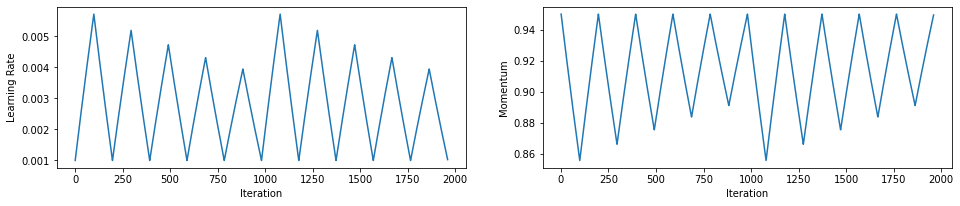

In [ ]:
clr.plot_lr((14, 3.5))

# 1Cycle Policy using pre-trained VGG16

In [ ]:
import math

class OneCycle(CyclicalLR):
  def __init__(self,
               max_lr,
               base_lr=None,
               div_factor=20,
               cyclical_momentum=True,
               base_momentum=0.85,
               max_momentum=0.95, 
               total_steps=None,
               epochs=None,
               steps_per_epoch=None,
               min_div_factor=1e4,
               inc_ratio=0.3,
               anneal='linear'):
    """Anneals the learning rate according to the 1cycle learning rate policy. In short,
    the 1cycle policy anneals the learning rate from a base learning rate to the maximum learning rate and then
    from there to the minimum learning rate (which is lower than the the base learning rate according to the author).

    Args:
        max_lr (float): The upper learning rate bound in the cycle.
        base_lr (float): The lower learning rate bound or the initial learning rate in the cycle. 
          If not provided, it is determined as max_lr/div_factor.
          Default: None
        div_factor (float or int): Determines the lower learning rate bound as max_lr/div_factor.
          Default: 20
        cyclical_momentum (bool): If ``True``, cyclical momentum will be used.
          Default: True
        base_momentum (float): The lower momentum bound or the initial momentum in the cycle.
          Default: 0.85
        max_momentum (float): The upper momentum bound in the cycle.
          Default: 0.95
        total_steps (int): The total number of steps in the cycle. If not provided,
          then it will be computed using epochs and steps_per_epoch.
        epochs (int): The number of epochs. 
        steps_per_epoch (int): The number of steps per epoch. Typically,
          equals to ceil(num_samples / batch_size).
        min_div_factor (float): Determines the minimum learning rate bound as base_lr/min_div_factor.
          Default: 1e4
        inc_ratio (float): The ratio of the cycle for increasing the learning rate from 0 to 1.
          Default: 0.3
        anneal (str): Type of annealing function used. One of {linear, cosine, exp}.
          Default: 'linear'
    """
    
    super().__init__(max_lr, base_lr, div_factor, cyclical_momentum, base_momentum, max_momentum)

    if total_steps is None and epochs is None and steps_per_epoch is None:
      raise ValueError('Either total_steps or (epochs and steps_per_epoch) must be defined.')
    elif total_steps is not None:
      self.total_steps = total_steps
    else:
      self.total_steps = epochs * steps_per_epoch

    if inc_ratio < 0 or inc_ratio > 1:
      raise ValueError(f'Expected 0 <= inc_ratio <= 1, got {inc_ratio}.')

    # Compute number of steps the learning rate goes up and down.
    # self.step_size_up = float(inc_ratio * self.total_steps) - 1
    self.step_size_up = float(inc_ratio * self.total_steps) - 1
    self.step_size_down = float(self.total_steps - self.step_size_up) - 1
  
    # Since the author wanted to keep decreasing the learning rate for several last iterations,
    # the min_lr is the smallest value the learning rate can be.
    self.min_lr = self.base_lr/min_div_factor

    if anneal == 'linear':
      self.annealer = self._lin_annealing
    elif anneal == 'exp':
      self.annealer = self._exp_annealing  
    else:
      self.annealer = self._cos_annealing

  def _exp_annealing(self, start, end, ratio):
    """Anneal exponentially from `start` to `end` as `ratio` goes from 0.0 to 1.0"""
    return start * (end/start) ** ratio

  def _cos_annealing(self, start, end, ratio):
    """Cosine anneal from `start` to `end` as `ratio` goes from 0.0 to 1.0"""
    return end + (start - end)/2.0 * (math.cos(math.pi * ratio) + 1)

  def _lin_annealing(self, start, end, ratio):
    """Anneal linearly from `start` to `end` as `ratio` goes from 0.0 to 1.0"""
    return start + (end - start) * ratio

  def get_lr(self):
    step_num = self.batch_counter

    # If the number of total steps defined smaller than the current epoch counter,
    # the learning rate will be negative.
    if step_num > self.total_steps:
      raise ValueError(f'Tried to step {step_num} times. The specified number of total steps is {self.total_steps}')

    if step_num <= self.step_size_up:
      lr = self.annealer(self.base_lr, self.max_lr, step_num/self.step_size_up)
    else:
      down_step_num = step_num - self.step_size_up
      lr = self.annealer(self.max_lr, self.min_lr, down_step_num/self.step_size_down)
  
    return lr

  def get_momentum(self):
    step_num = self.batch_counter

    if step_num > self.total_steps:
      raise ValueError(f'Tried to step {step_num} times. The specified number of total steps is {self.total_steps}')

    if step_num <= self.step_size_up:
      momentum = self.annealer(self.max_momentum, self.base_momentum, step_num/self.step_size_up)
    else:
      down_step_num = step_num - self.step_size_up
      momentum = self.annealer(self.base_momentum, self.max_momentum, down_step_num/self.step_size_down)
    
    return momentum

In [ ]:
batch_size = 512
epochs = 1
max_lr = 0.006
min_div_factor = 1e7
steps_per_epoch = math.ceil(len(X_train_scaled) / batch_size)

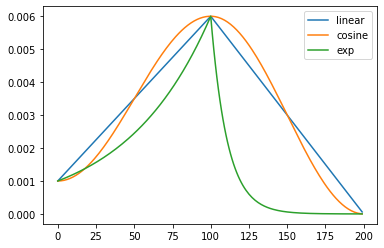

In [ ]:
def test_anneal(anneal, start, end, min):
  one_cycle = OneCycle(max_lr=max_lr, cyclical_momentum=True,
                          epochs=epochs, steps_per_epoch=steps_per_epoch,
                          anneal=anneal, min_div_factor=min_div_factor, inc_ratio=0.5)
  
  arr = []
  for i in range(100):
    arr.append(one_cycle.annealer(start, end, i / 100))
  
  for i in range(100):
    arr.append(one_cycle.annealer(end, min, i / 100))

  plt.plot(range(200), arr, label=anneal)
  plt.legend()

test_anneal('linear', 0.001, 0.006, 0.006/1e4)
test_anneal('cosine', 0.001, 0.006, 0.006/1e4)
test_anneal('exp', 0.001, 0.006, 0.006/1e4)

## Linear Annealing with 1Cycle Policy

In [ ]:
model = build_momentum_vgg16_model()

print(f'Training with {steps_per_epoch} steps per epoch')

one_cycle = OneCycle(max_lr=max_lr, base_lr=base_lr, cyclical_momentum=True,
                          epochs=epochs, steps_per_epoch=steps_per_epoch,
                          anneal='linear', min_div_factor=min_div_factor, inc_ratio=0.5)

history = model.fit(X_train_scaled, y_train,  
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_test_scaled, y_test),
          callbacks=[one_cycle])

Training with 98 steps per epoch
98/98 [==============================] - 6s 63ms/step - loss: 1.9124 - accuracy: 0.3444 - val_loss: 1.5429 - val_accuracy: 0.4769


Let's plot the learning rate and see if it follows the policy.

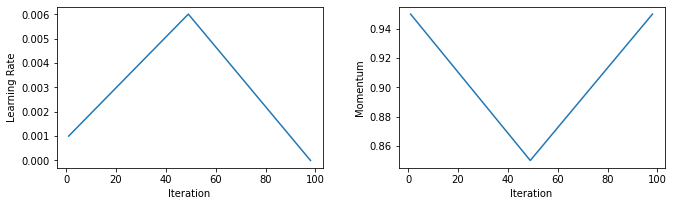

In [ ]:
one_cycle.plot_lr((10,3.5))

## Cosine Annealing with 1Cycle Policy

In [ ]:
model = build_momentum_vgg16_model()

print(f'Training with {steps_per_epoch} steps per epoch')

one_cycle = OneCycle(max_lr=max_lr, base_lr=base_lr, cyclical_momentum=True,
                          epochs=epochs, steps_per_epoch=steps_per_epoch,
                          anneal='cosine', min_div_factor=min_div_factor)

history = model.fit(X_train_scaled, y_train,  
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_test_scaled, y_test),
          callbacks=[one_cycle])

Training with 98 steps per epoch
98/98 [==============================] - 6s 62ms/step - loss: 1.8957 - accuracy: 0.3503 - val_loss: 1.5508 - val_accuracy: 0.4728


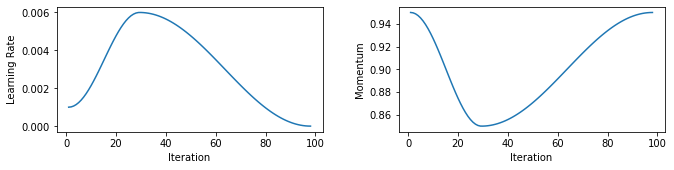

In [ ]:
one_cycle.plot_lr()

## Exponentially Annealing with 1Cycle Policy

In [ ]:
model = build_momentum_vgg16_model()

print(f'Training with {steps_per_epoch} steps per epoch')

one_cycle = OneCycle(max_lr=max_lr, cyclical_momentum=True,
                          epochs=epochs, steps_per_epoch=steps_per_epoch,
                          anneal='exp', min_div_factor=min_div_factor)


history = model.fit(X_train_scaled, y_train,  
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_test_scaled, y_test),
          callbacks=[one_cycle])

Training with 98 steps per epoch
98/98 [==============================] - 6s 62ms/step - loss: 2.1574 - accuracy: 0.2445 - val_loss: 2.0694 - val_accuracy: 0.3122


The **momentum** seems to be like linear because its value is too close to 1.

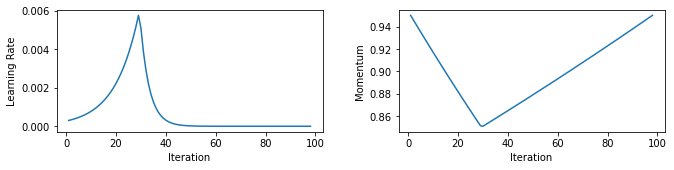

In [ ]:
one_cycle.plot_lr()